## Baseline model for the lung pressure prediction in a mechanical ventilator

As a starting point, here we develop a baseline model to predict the lung pressure using the data from a mechanical ventilator developed <br>
by PVP (People's Ventilator Project). This can then be used as a reference to compare the performance of other ML models in the later stages!

### What is a baseline model? Why is it useful?

A baseline model is essentially a simple model that acts as a reference in a machine learning project. Its main function is to contextualize <br> the results of trained models. Baseline models usually lack complexity and may have little predictive power. Regardless, their inclusion is <br> a necessity for many reasons.

Importing the packages

In [21]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import fftpack
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.optimize import curve_fit, differential_evolution
from tqdm import tqdm
from xgboost import XGBRegressor, cv
from sklearn .model_selection import train_test_split, KFold, RandomizedSearchCV, GridSearchCV
from random import sample
import xgboost as xgb
import sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error
import datetime, time, os
import warnings 
warnings.filterwarnings("ignore")

RSEED=42
np.random.seed(RSEED)

### Polynomial regression

Polynomial regression is a form of linear regression analysis in which the relationship between the independent variable x (4 features in our case) and the dependent variable y (pressure here) is modelled as an nth degree polynomial in x (2 here)

We choose our baseline model to be a Linear regression with polynomial function of degree 2 on the basic 4 feature: <br> 
Input flow, output flow, Resistance(R) and Compliance(C)

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

Importing the data

In [4]:
df1=pd.read_csv('data/train.csv')

In [15]:
#checking the dataframe
df1.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [19]:
#checking for null values
df1.isnull()
df1.isnull().values.any()

False

Selecting the features to be included in the baseline model

In [5]:
col_lin = ['u_in', 'u_out', 'R', 'C', 'pressure']
lin_reg_data = df1[col_lin]

Splitting the data in to train and test

In [6]:
#train test split
target_pol="pressure"
X_poly = df1.drop(target_pol, axis=1)
y_poly = df1.loc[:,target_pol].values

X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y_poly, test_size = 0.3, shuffle=False)

Polynomial function of degree 2

Fitting the polynomial function to the features in train and test data

In [7]:
poly5 = PolynomialFeatures(2)
X_train_poly5 = poly5.fit_transform(X_train_poly)
X_test_poly5 = poly5.transform(X_test_poly)

Defining the linear regression

Fitting the model on train data and making predictions on train data

In [8]:
model5 = linear_model.LinearRegression()

model5.fit(X_train_poly5, y_train_poly)
train_pol_pred5 = model5.predict(X_train_poly5)

Calculating the Mean Absolute error(MAE) and mean square error(MSE) for the predictions on train data 

In [9]:
# Evaluting model
mae_train5 =  mean_absolute_error(y_train_poly, train_pol_pred5).round(2)
mse_train5 = mean_squared_error(y_train_poly, train_pol_pred5).round(2)
print('MAE-train:', mae_train5)
print('MSE-train', mse_train5)

MAE-train: 3.25
MSE-train 28.94


Making predictions on test data and calculating the MAE and MSE on test data

In [10]:
test_poly_pred5 = model5.predict(X_test_poly5)
mae_test5 =  mean_absolute_error(y_test_poly, test_poly_pred5).round(2)
mse_test5 = mean_squared_error(y_test_poly, test_poly_pred5).round(2)
print('MAE-test:', mae_test5)
print('MSE-test', mse_test5)

MAE-test: 3.38
MSE-test 29.08


Plotting the true values of pressure with predicted values of pressure

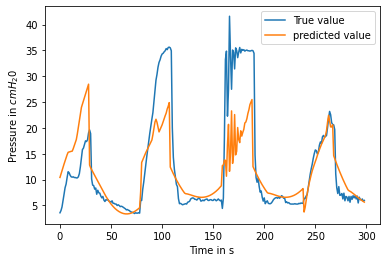

In [11]:
plt.plot(y_test_poly[1:300], label='True value')
plt.plot(test_poly_pred5[1:300], label='predicted value')
plt.ylabel('Pressure in $cmH_20$')
plt.xlabel('Time in s')
plt.legend()
plt.show()


Making the about plot transparent and elegant for using it for the presentation

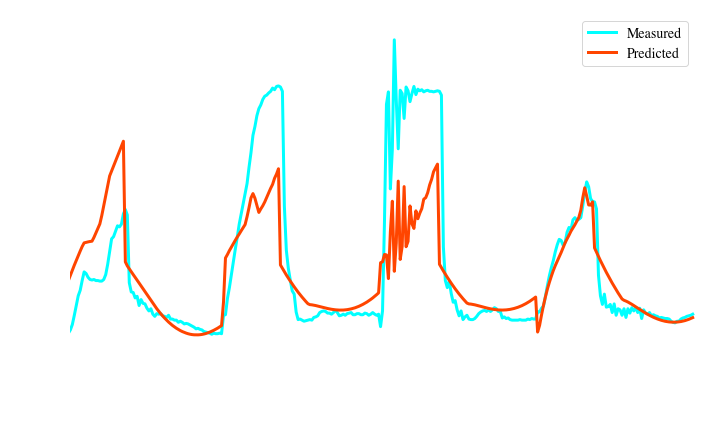

In [38]:
tickcolor = 'white'
spinecolor = 'white'
labelcolor = 'white'
titlecolor = 'white'
import matplotlib as mpl
mpl.rc('text', usetex=False)
tick_fsize=22
label_size=22
fig=plt.figure(figsize=(10,6))
ax1=plt.subplot(111)
ax1.spines['bottom'].set_linewidth(1.)
ax1.spines['left'].set_linewidth(1.)
ax1.set_xticks([0, 319/12, 2*319/12, 3*319/12, 4*319/12, 5*319/12, 6*319/12, 7*319/12, 8*319/12, 9*319/12, 10*319/12, 11*319/12, 12*319/12])
plt.plot(y_test_poly[1:320], linewidth=3, color='cyan')
plt.plot(test_poly_pred5[1:320], linewidth=3, color='orangered')
#plt.ylabel(r'Pressure in cm$H_2O$')
#plt.xlabel('Time in s')
#plt.legend()
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_color(spinecolor)
ax1.spines['left'].set_color(spinecolor)
ax1.spines['bottom'].set_linewidth(3.)
ax1.spines['left'].set_linewidth(3.)
ax1.set_xticklabels(np.arange(0,13, 1),fontsize=tick_fsize, color=tickcolor)
ax1.set_yticklabels(np.arange(0,46,5),fontsize=tick_fsize, color=tickcolor)
ax1.set_xlabel(r'Time in s ', fontsize=label_size, color=labelcolor)
ax1.set_ylabel(r'Pressure in cmH$_2$O', fontsize=label_size, color=labelcolor)
ax1.tick_params('x', size=9, width=3., colors='white')
ax1.tick_params('y', size=9, width=3., colors='white')
plt.xlim(0,319)
plt.ylim(0,45)
ax1.legend(labels=['Measured', 'Predicted'], fontsize=14)
plt.tight_layout()
plt.savefig('baseline.png', transparent=True)